# Labelisation: Finding the rotation

## Intro

The goal of this notebook is to find the transformation from the coordinates of the microscope to the coordinates of the final stiched image in Prince

## Set up

In [9]:
from amftrack.util.sys import data_path, get_current_folders, update_plate_info
from amftrack.util.file import chose_file
from amftrack.util.plot import show_image
from amftrack.pipeline.functions.image_processing.experiment_class_surf import Experiment
import os
import matplotlib.pyplot as plt
import logging
#%matplotlib notebook

In [2]:
import logging
import os
logger = logging.getLogger("PIL.TiffImagePlugin")
logger.setLevel("INFO")

logger = logging.getLogger("urllib3")
logger.setLevel("INFO")

## I/ Points of interest

Find the coordinates of the image taken on the microscope

### 1/ Close up image

In [3]:
image_name = "20220324_Plate907_046"

In [4]:
image_path = chose_file(os.path.join(data_path, "width1/groundtruth", image_name))

In [5]:
i = 0

<IPython.core.display.Javascript object>


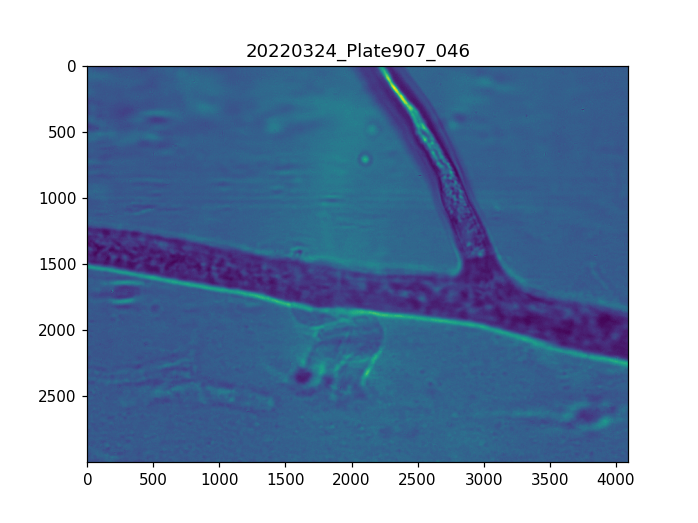

Text(0.5, 1.0, '20220324_Plate907_046')

In [10]:
show_image(image_path)
plt.title(image_name)

Find the position on the image

Coordinates of the image

In [21]:
coord_of_image = [51620, 55480]

Original position of the point of interest:

### 2/ Snapshot

Text(0.5, 1.0, '046_Image__2022-03-24__12-51-26.tiff')

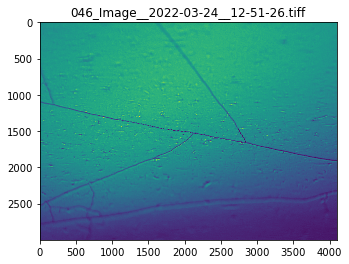

In [8]:
snapshot_name = "046_Image__2022-03-24__12-51-26.tiff"
snapshot_path = os.path.join(data_path, "width1/snapshot/20220324_Plate907_Snapshots", snapshot_name)
show_image(snapshot_path)
plt.title(snapshot_name)

## II/ Finding the points on the stiched image

### 1/ Loading the experiment object

#### Loading the experiment object:

In [11]:
directory = "/data/felix/width1/full_plates/"
plate_name = "20220325_1423_Plate907"
update_plate_info(directory)
folder_df = get_current_folders(directory)

2022-04-22 12:28:26,294-[INFO]- dropbox:471 -> Request to files/download


analysed:   0%|          | 0/2 [00:00<?, ?it/s]

2022-04-22 12:28:28,691-[INFO]- dropbox:471 -> Request to files/upload
2022-04-22 12:28:29,707-[INFO]- dropbox:471 -> Request to files/download


In [12]:
selected_df = folder_df.loc[folder_df['folder']==plate_name]

In [13]:
selected_df

,total_path,Plate,PrincePos,root,strain,medium,split,Pbait,CrossDate,Temperature,...,/Analysis/skeleton_pruned_compressed.mat,/Analysis/transform.mat,/Analysis/transform_corrupt.mat,/Analysis/skeleton_realigned_compressed.mat,/Analysis/nx_graph_pruned.p,/Analysis/nx_graph_pruned_width.p,/Analysis/nx_graph_pruned_labeled.p,date,folder,Temp
12705,/data/felix/width1/full_plates/20220325_1423_P...,907,9,'Carrot','A5','001P100N100C','Y','-',20220321,25,...,True,False,False,True,True,False,False,"25.03.2022, 14:23:",20220325_1423_Plate907,NaN


In [14]:
i = 0

In [15]:
plate = int(list(selected_df['folder'])[i].split('_')[-1][5:])
folder_list = list(selected_df['folder'])
directory_name = folder_list[i]

In [16]:
exp = Experiment(plate, directory)
exp.load(selected_df.loc[selected_df['folder']==directory_name],labeled=False)

2022-03-25 14:23:00


In [17]:
len(exp.nx_graph[0])

2407

## 2/ Display the full image

In [18]:
import numpy as np
from pymatreader import read_mat
import cv2
from amftrack.plotutil import plot_t_tp1

In [19]:
folder_list = list(selected_df['total_path'])
folder_list.sort()
skels = []
ims = []
kernel = np.ones((5,5),np.uint8)
itera = 1
start = 0

finish = start+2
for folder in folder_list[start:finish]:
    path_snap=folder
    skel_info = read_mat(path_snap+'/Analysis/skeleton_pruned_compressed.mat')
    skel = skel_info['skeleton']
    skels.append(cv2.dilate(skel.astype(np.uint8),kernel,iterations = itera))
    im = read_mat(path_snap+'/Analysis/raw_image.mat')['raw']
    ims.append(im)

<IPython.core.display.Javascript object>


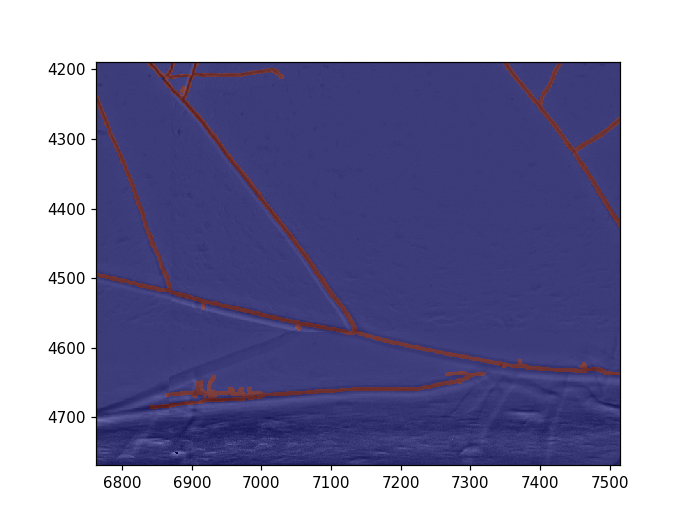

In [20]:
%matplotlib notebook
plt.close('all')
start = 0
finish = start + 1
for i in range(start,finish):
    plot_t_tp1([], [], None, None, skels[i], ims[i])

In [31]:
coord_prince_compressed = [7130, 4574]

In [32]:
facteur = 1.725 * 5 # convert to um and get rid of the compression

In [33]:
coord_prince = [coord_prince_compressed[0]*facteur, coord_prince_compressed[1]*facteur]

#### Get one or several images for each point of interest

## Bilan

In [34]:
def affichage():
    print(f"""
    POINT \n
    image: {image_name}
    snapshot: {snapshot_name}
    coord_image: (um) {coord_of_image}
    prince (compressed in pixels): {coord_prince_compressed}
    prince (um): {coord_prince}\n""")

In [35]:
affichage()


    POINT 

    image: 20220324_Plate907_046
    snapshot: 046_Image__2022-03-24__12-51-26.tiff
    coord_image: (um) [51620, 55480]
    prince (compressed in pixels): [7130, 4574]
    prince (um): [61496.25, 39450.75]



### Points

## Get the transformation

In [27]:
from amftrack.util.image_analysis import find_transformation

In [36]:
old_coord = [[68820, 45880], [54600, 41080], [54220, 39720], [51620, 55480]]
old_coord_pix = [[68820/1.725, 45880], [54600, 41080], [54220, 39720], [51620, 55480]]
new_coord_pix = [[9235*5, 3300*5], [7484*5, 2828*5], [7412*5, 2656*5], [7130*5, 4574*5]]
find_transformation(old_coord_pix, new_coord_pix)

(array([[-0.44187215,  0.89707804],
        [ 0.89707804,  0.44187215]]),
 array([ 20354.00234011, -48354.53600433]))

## BROUILLON

In [76]:
import numpy as np
a = np.linalg.norm(np.array([62680, 38280])-np.array([68820, 45880]))
b = np.linalg.norm(np.array([9235, 3300])-np.array([8379, 2500]))
print(a)
print(b)
print(a/b)

9770.342880370166
1171.6381694021409
8.339044540820773
